# Activity 2.1. Linear Regression
## Introduction
In this activity you learn how to use an optimization algorithm, called <font color='red'>**Stochastic Gradient Descent (SGD)**</font>, to build a linear model for regression. In Activity 2, you will be asked to expand the linear regression implementation and develop **Ridge Regression algorithm (linear regression <font color='red'>with $L_2$ regularization</font>).**

## Instructions

Generate a synthetic dataset suitable for regression and divide it to train and test sets, Choose and implement:
- Basis function $\pmb{\phi}$ (<font color='blue'>*phi*</font>)
- Initialize weight vector $\pmb{w}$ (<font color='blue'>*w*</font>)
- Learning rate $\eta$ (<font color='blue'>*eta*</font>)
- Termination threshold $\epsilon$ (<font color='blue'>*epsilon*</font>).

Use the above function and repeat the following **until <font color='red'>the difference</font> between the old and new weight vectors becomes  <font color='red'>small enough</font> (less than the threshold)**:
$$d(\pmb{w}^{\tau+1}, \pmb{w}^{\tau}) \leq\epsilon$$

- **Shuffle** the training data
- For each datapoint in the training data do:

$$\pmb{w}^{(\tau+1)} := \pmb{w}^{(\tau)} + \eta (t - {\pmb{w}^{(\tau)}}\pmb{\phi}_n) \pmb{\phi}_n$$

> - Plot the weights $\pmb{w}^{\tau}$ vs. iteration number $\tau$.  
> - Plot the training and testing errors vs. iteration number $\tau$. 

Repeat the above experiments using different datasets, random seeds, initial weights, and $\epsilon$ value


> **Note**: 
- `:=` is a notation borrowed from computer science, it means the left hand-side  of this notation *'is defined by'* the right hand-side. For example, $y:= 7x+2$, which mean `y` is defined by `7x+2`.  
- `=` means equality. For example, $1=sin^2(\theta)+cos^2(\theta)$, it is notable that the `1` just the result of $sin^2(\theta)+cos^2(\theta)$, but it doesn't indicate `1` is defined by $sin^2(\theta)+cos^2(\theta)$.

## Implementation
### Dataset
Let start with loading libraries and generateing a synthetic dataset, as follows. Here, we generate $N$ data points generated uniformly at random (using `runif`). We then choose a **weight vector** (called `coeff`) using which we produce the corresponding target value for each data point.  In the training time, we pretend that we don't know the weight vector and we try to learn it using the generated training dataset.

In [1]:
library(ggplot2) # for plotting functions.
library(reshape2) # for melt and cast functions
library(repr)
set.seed(3092018) # to make the results of stochastic methods reproducible

In [2]:
# geberate N x D data samples
N <- 200 # number of all data point (test and train)
D <- 4   # number of features/attributes
data <- data.frame(matrix(runif(D*N), nrow=N, ncol=D)) # randomly generate data from Uniform distribution

**Matrix manipulation operator**:

- Build matrix
```r
> A <- matrix(data = c(1,3,5,2,4,6), nrow = 3, ncol = 2)
> A
       [,1]  [,2]
[1,]   1     2
[2,]   3     4
[3,]   5     6
```

- Unit & Zero matrix
```r
> matrix(1,3,2)
       [,1]  [,2]
[1,]   1     1
[2,]   1     1
[3,]   1     1
> matrix(0,3,2)
       [,1]  [,2]
[1,]   0     0
[2,]   0     0
[3,]   0     0
```

- Diagonal matrix & Identity Matrix
```r
> S <- matrix(c(2,1,3,3,2,1,1,3,2),3,3)
> diag(S)
[1] 2 2 2
> diag(diag(S)) # Diagonal matrix
        [,1]  [,2]  [,3]
[1,]   2     0     0
[2,]   0     2     0
[3,]   0     0     2
> diag(c(1,1,1)) # Identity Matrix
        [,1]  [,2]  [,3]
[1,]   1     0     0
[2,]   0     1     0
[3,]   0     0     1
```

- Is a matrix
```r
> is.matrix(A)
[1] TRUE
```

- Multiplication by a Scalar:
```r
> c <- 3
> c * A
       [,1]  [,2]
[1,]    3     6
[2,]    9    12
[3,]   15    18
```

- Matrix Addition & Subtraction:
```r
> B <- matrix(data = c(1,0,0,0,0,0), nrow = 3, ncol = 2)
> A + B
       [,1]  [,2]
[1,]   2     2
[2,]   3     4
[3,]   5     6
> A - B
       [,1]  [,2]
[1,]   0     2
[2,]   3     4
[3,]   5     6
```

- Matrix multiplication:
```r
> C <- matrix(data = c(1,1,3,3,4,4), nrow = 2, ncol = 3)
> A %*% C
         [,1]   [,2]   [,3]
[1,]     3	   9    12
[2,]     7	  21	28
[3,]    11	  33	44
> C %*% A
        [,1]  [,2] 
[1,]   30	38
[2,]   30	38
```

- Transpose of a Matrix:
```r
> t(A)
       [,1]  [,2]  [,3]
[1,]   1     3     5
[2,]   2     4     6
```

In [3]:
# generate the labels
# the real coefficient to be estimated: -5, -3, 4, 5, 10
coeff <- matrix(c(-5,-3,4,5,10), D+1, 1)

# calculate target value 'Y' for each set of data
data <- cbind(data,'Y'=as.matrix(cbind(1,data[,1:D])) %*% coeff)

In [4]:
# add gaussian noise the labels (just to make it a little bit more challenging)
data$Y <- data$Y + rnorm(N, mean = 0, sd =1) # adding noise
#pairs(data) # matrix of scatterplots

Now, divide the dataset into testing and training sets

In [5]:
# divide data into training and testing sets
train.len <- N/2

# do shuffle
index <- sample(1:N,train.len)

# preparing train dataset
train.data <- data[index, -5]
train.label <- data[index, 5]

#preparing test dataset
test.data <- data[-index, -5]
test.label <- data[-index, 5]

## Implementation
Now, based on the instruction, we initialize the parameter values.

### Auxilary Functions
To produce a clean and readable code, let us first define some auxiliary function that calculate the prediction and cost based on the projected data and estimated coefficients.

In [6]:
# calculate predict value based on the estimated coefficients
predict_func <- function(Phi, w){
    return(Phi %*% w) # matrix multiplication
} 

### Cost (Lost) function

The sum-of square error function:  
$$E_{D}(w)=\frac{1}{2}\sum_{n=1}^{N}{\{t_{n}-\pmb{w}^{T}\pmb{\phi}(x_{n})\}^2}$$
> **Note**: In above formula, $w$ is a row vector, using $w^{T}$ is just to make it as column vector

In [7]:
# auxiliary function to calculate a cost(lost) function
# w in here is a column vector, we dont need to transpose it
error_func <- function (Phi, w, label){
    return(sum((predict_func(Phi, w) - label)^2)/2)
}

### Initialization

* Add a column of 1 into the dataset: the dummy 'basis function' $\phi_{0}(x)=1$ for the bias parameter $w_{0}$
$$y(x,w)=w_{0}\phi_{0} + \sum_{j=1}^{M-1}{w_{j}\phi_{j}(x)}= \sum_{j=0}^{M-1}{w_{j}\phi_{j}(x)}=\pmb{w}^{T}\pmb{\phi}{(x)}$$

In [8]:
# project data using a basis function (identical here)
Phi <- as.matrix(cbind('X0'=1, train.data))

To declutter the expression, let's $\pmb{\phi}_n = \pmb{\phi}(x_{n})$.  
the gradient of the error function: 
$$E^{'}_{D}(w) = \nabla{E_{D}(w)} = -(\pmb{t} - {\pmb{w}^{(\tau)}}\pmb{\phi}_n) \pmb{\phi}_n$$
By using it, we have:
$$\pmb{w}^{(\tau+1)} := \pmb{w}^{(\tau)} - \eta \nabla{E_{D}(w)}= \pmb{w}^{(\tau)} + \eta (\pmb{t} - {\pmb{w}^{(\tau)}}\pmb{\phi}_n) \pmb{\phi}_n$$

In [9]:
T <- train.label # rename just for conviniance: T for target value
tau.max <- 10000 # maximum number of iterations
eta <- 0.05 # learning rate (have impact on lost function)
epsilon <- 0.1 * mean(T) # a threshold on the cost (to terminate the process)

For recording the process of estimating

In [10]:
W <- matrix(NA,nrow=tau.max, ncol=ncol(Phi)) # be used to store the estimated coefficients

Setting initial starting weight

In [11]:
W[1,] <- runif(ncol(Phi))

For recording error rate

In [12]:
error <- data.frame('tau'=1:tau.max)  # to be used to trace the test and training errors in each iteration

### Main Function

In [13]:
T <- train.label
tau.max <- 10000
eta <- 0.005
epsilon <- 0.1 * mean(T) 

Phi <- as.matrix(cbind('X0'=1, train.data))
W <- matrix(NA,nrow=tau.max, ncol=ncol(Phi))
W[1,] <- runif(ncol(Phi))
error <- data.frame('tau'=1:tau.max)

In [14]:
# Setting the loop trigger and terminator
tau <- 1 # iteration counter starts from 1
terminate <- FALSE # initialise for the loop

In [15]:
while(!terminate){
    # check termination criteria:
    # Criteria 1: excess the number of iteration  tau >= tau.max
    # Criteria 2: the change of the value of weight is samller than the threshold
    terminate <- ( tau >= tau.max ) | ( error_func(Phi, W[tau,],T) <= epsilon )
    
    # shuffle data: (Not necessary)
    #train.index <- sample(1:train.len, train.len, replace = FALSE)
    #Phi <- Phi[train.index,]
    #T <- T[train.index]
    
    # for each datapoint:
    for (i in 1:train.len){ # i for row
        # check termination criteria:
        condition <- (tau >= tau.max) | (error_func(Phi, W[tau,], T) <= epsilon)
        if (condition) {terminate<-TRUE;break}
        
        # perdiction made by the estimated weight
        # Note: that is why we need to give a initial start for this process
        t_pred = predict_func(Phi[i,], W[tau,])
        
        # for each coefficient:
        for (j in 1: ncol(W)){ #j for column
            # update the coefficient in every iteration:
            W[(tau+1),j] <- W[tau,j] + eta * (T[i]-t_pred) * Phi[i,j]
        }
        
        # temporarily add 1 to the original data matrix
        tmp_train.data <- as.matrix(cbind(1, train.data))
        tmp_test.data <- as.matrix(cbind(1, test.data))
        
        # calculate and record the error at each iteration with current weights:
        error[tau, 'train'] <- error_func(tmp_train.data, W[tau,], train.label)
        error[tau, 'test'] <- error_func(tmp_test.data, W[tau,], test.label)
        
        # update the counter:
        tau <- tau + 1        
    }
}

In [16]:
error.m <- melt(error[1:tau,], id='tau')
# the final result is:
w <- W[tau,]
cat('Learning rate:', eta, 'Iteration:', tau, '\n')
cat('The  real coefficents are:',coeff,'\nThe  final coefficents are:',w)

Learning rate: 0.005 Iteration: 10000 
The  real coefficents are: -5 -3 4 5 10 
The  final coefficents are: -3.646411 -3.406808 4.285677 4.019625 9.060785

In [20]:
error.m

tau,variable,value
1,train,629.9153
2,train,631.9738
3,train,614.0098
4,train,612.3559
5,train,616.8543
6,train,606.5111
7,train,606.7308
8,train,607.6471
9,train,596.4736
10,train,598.2689


### Visualizations

  Let's plot the errors of the learned weight vectors over the training iterations on the training and test sets.

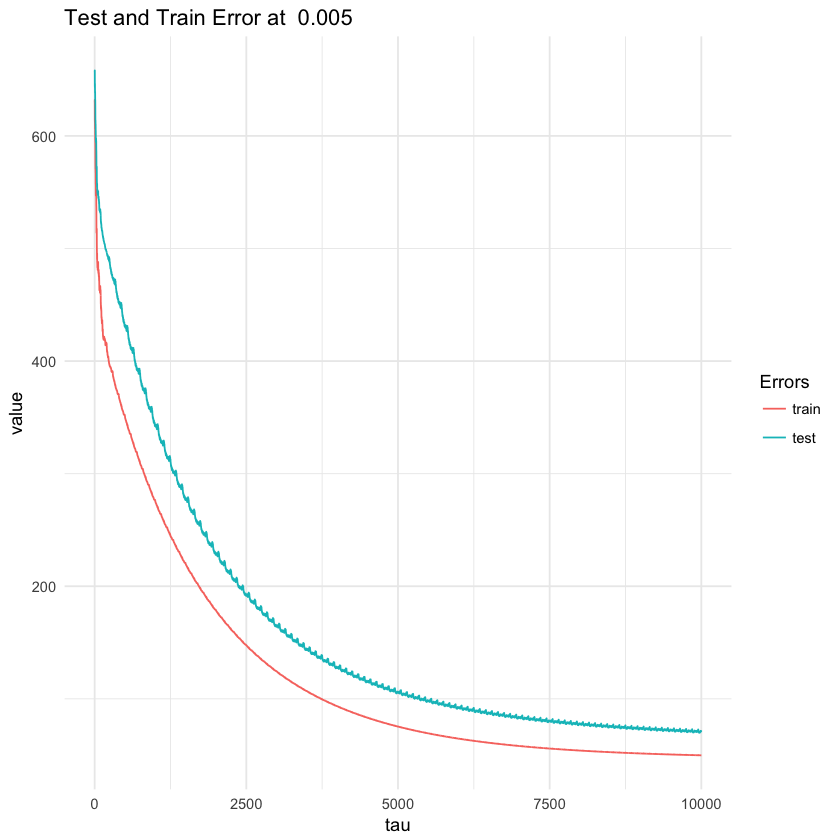

In [17]:
options(warn=-1)
ggplot(data=error.m, aes(x=tau, y=value, color=variable)) +
    geom_line() + ggtitle(paste('Test and Train Error at ',eta)) +
    scale_color_discrete(guide = guide_legend(title = 'Errors')) +theme_minimal()

Now let's plot the elements of the learned weight vectors over the training iterations.

In [18]:
W.m <- as.data.frame(W); names(W.m)<-c('w0','w1','w2','w3','w4')
W.m$tau<-1:nrow(W)
W.m <-melt(W.m, id='tau'); names(W.m) <- c('tau', 'coefficients', 'values')

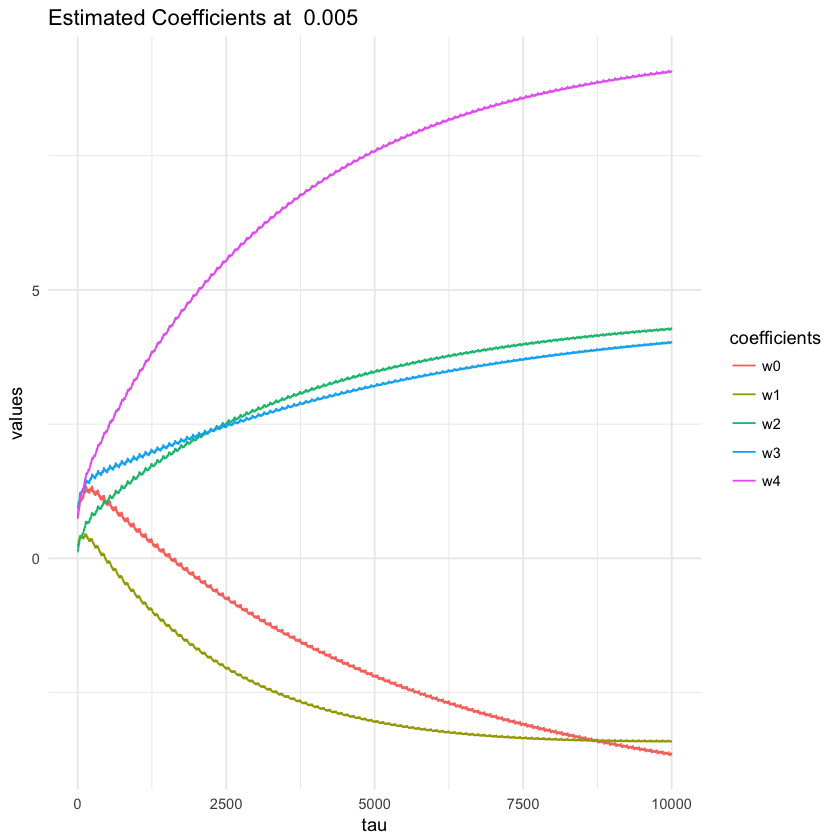

In [19]:
ggplot(data=W.m, aes(x=tau, y=values, color=coefficients)) + 
    geom_line() + ggtitle(paste('Estimated Coefficients at ', eta))+ theme_minimal()

## Discussions

- How the learning rate can affect the convergence rate (i.e., when the algorithm stops improving) and prediction error? Choose some other constant values for the learning rate and investigate their effects.  

> $\eta=0.005$, @10000;  
> $\eta=0.007$, @7500;  
> $\eta=0.01$, @5000;  
> $\eta=0.03$, @1500;  
> $\eta=0.05$, @1250. 

> The choice of $\eta$
> <font color='blue'>0.001:  -5.309966 -2.821733 4.392642 5.180241 10.02833 </font>    
> <font color='blue'>0.005:  -4.487677 -2.985412 4.171416 4.574873 9.602247</font>   
> <font color='red'>0.007:  -4.98524 -2.913043 4.325839 4.964415 9.897129</font>    
> <font color='blue'>0.008:  -5.142671 -2.869944 4.374413 5.088407 9.972178 </font>    
> <font color='blue'>0.009:  -5.240726 -2.840698 4.405914 5.167123 10.015</font>  
> <font color='blue'>0.01:   -5.314404 -2.816114 4.429475 5.226238 10.04579</font>  
> <font color='blue'>0.05:   -5.429842 -2.794818 4.542759 5.468462 10.19376</font>  

- Do you believe having different learning rates at different iterations of the main learning loop can help? If it matters, is it better to have large values at start and smaller when close to finish or the other way around?  

> [“... the lower the value of $\eta$, the slower we travel along the downward slope. While this might be a good idea (using a low learning rate) in terms of making sure that we do not miss any local minima, it could also mean that we’ll be taking a long time to converge — especially if we get stuck on a plateau region”](https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10)  
> - If the value of $\eta$ is too small, gradient descent can be slow;     
> - If it is too large, gradient descent can overshoot the minimum, it may fail to converge or even diverge.  

> The learning rate affects how quickly our model can converge to a local minima, a right learning rate means lesser time for us to train the model. (Less training time, lesser money spent on CPU cloud compute)

> ![](http://cs231n.github.io/assets/nn3/learningrates.jpeg)
Pic From [Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/neural-networks-3/)

> To estimate a good learning rate, by training the model initially with a very low learning rate and increasing it (either linearly or exponentially) at each iteration.

> If we record the learning at each iteration and plot the learning rate (log) against loss:

![](https://cdn-images-1.medium.com/max/1600/0*Ibt82oiSXBw6YbGm.)

> As the learning rate increase, there will be a point where the loss stops decreasing and starts to increase. The learning rate should be somewhere to the left to the lowest point.

- Validate your intuition using monotonically increasing or decreasing learning rates as functions of $\tau$ (e.g. try $\frac{a}{b+\tau}$ for different values of $a$ and $b$).  

> 

- Modify your code and develop a batch gradient descent. The main difference is that you do not need to shuffle the training data, but have to include all training samples in the calculation of the weight updates in each iterations. Compare and discuss the convergence rates and final training error for SGD and batch GD.

> 